In [2]:
!pip install tensorflow-text

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 21.8 MB/s eta 0:00:00


In [3]:
from tensorflow.keras.preprocessing.text import one_hot
import tensorflow_hub as hub
import tensorflow_text as text
import pandas as pd
import tensorflow as tf

In [4]:
df=pd.read_csv('/content/drive/MyDrive/Dataset/spam.csv')

In [5]:
df.head()

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [6]:
df=df.drop_duplicates()

In [7]:
df.groupby('Category').describe()

Message                                                            \
           count unique                                                top   
Category                                                                     
ham         4516   4516  Go until jurong point, crazy.. Available only ...   
spam         641    641  Free entry in 2 a wkly comp to win FA Cup fina...   

               
         freq  
Category       
ham         1  
spam        1

In [8]:
641*100/4516

14.193976970770594

**SO 14.2 Emails are spam and rest is ham that means there's data imbalance**

**So we will use Downsampling where ham data sample will be equal to the spam data samples by random sampling**

In [9]:
df_spam = df[df['Category']=='spam']
print(df_spam.shape)

df_ham = df[df['Category']=='ham']
print(df_ham.shape)


df_ham_downsampled = df_ham.sample(df_spam.shape[0])
print(df_ham_downsampled.shape)

(641, 2)
(4516, 2)
(641, 2)


In [10]:
df=pd.concat([df_ham_downsampled, df_spam])

In [11]:
df['spam']=df['Category'].apply(lambda x: 1 if x=='spam' else 0)
df.sample(5)

,Category,Message,spam
377,ham,You could have seen me..i did't recognise you ...,0
2189,spam,FREE camera phones with linerental from 4.49/m...,1
5427,spam,Santa Calling! Would your little ones like a c...,1
1777,spam,Call FREEPHONE 0800 542 0578 now!,1
5200,spam,Call Germany for only 1 pence per minute! Call...,1


In [12]:
df['spam'].unique()

array([0, 1])

In [13]:
df.reset_index()

,index,Category,Message,spam
0,3414,ham,Where do you need to go to get it?,0
1,5195,ham,Darren was saying dat if u meeting da ge den w...,0
2,1409,ham,"I've got ten bucks, jay is being noncomittal",0
3,1901,ham,And miss vday the parachute and double coins??...,0
4,2778,ham,Kind of. Took it to garage. Centre part of exh...,0
...,...,...,...,...
1277,5537,spam,Want explicit SEX in 30 secs? Ring 02073162414...,1
1278,5540,spam,ASKED 3MOBILE IF 0870 CHATLINES INCLU IN FREE ...,1
1279,5547,spam,Had your contract mobile 11 Mnths? Latest Moto...,1
1280,5566,spam,REMINDER FROM O2: To get 2.50 pounds free call...,1


In [14]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
# Strtaify is used to distribute both types of Samples equaly
X_train, X_test, y_train, y_test = train_test_split(df['Message'],df['spam'], stratify=df['spam'])
X_train.head(4)

4474                             S but not able to sleep.
2693    Urgent Urgent! We have 800 FREE flights to Eur...
4863    **FREE MESSAGE**Thanks for using the Auction S...
787     It does it on its own. Most of the time it fix...
Name: Message, dtype: object

## 1.) Functional API Neural Network

### Loading Distill BERT

In [15]:
# Input layer for text data
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string)

# BERT preprocessor layer (distilBERT)
preprocessor = hub.KerasLayer(
    "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3",
    name="bert_preprocessor"
)
encoder_inputs = preprocessor(text_input)

# Smaller BERT encoder layer (distilBERT)
encoder = hub.KerasLayer(
    "https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1",
    trainable=True,
    name="bert_encoder"
)
outputs = encoder(encoder_inputs)
pooled_output = outputs["pooled_output"]

## Building the Neural Network

Now what we did here is

In [16]:
# Adding an additional dense hidden layer
dense_units_1 = 64
dense_layer_1 = tf.keras.layers.Dense(dense_units_1, activation='relu')(pooled_output)

# Adding one more hidden layer
dense_units_2 = 32
dense_layer_2 = tf.keras.layers.Dense(dense_units_2, activation='relu')(dense_layer_1)

# Output layer
output_layer = tf.keras.layers.Dense(1, activation='sigmoid')(dense_layer_2)

# Create the model
model = tf.keras.Model(inputs=text_input, outputs=output_layer)

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=5, batch_size=32, validation_split=0.2)

# Evaluate the model
accuracy = model.evaluate(X_test, y_test)[1]
print(f"Accuracy: {accuracy}")

Epoch 1/5
24/24 [==============================] - 35s 933ms/step - loss: 0.2716 - accuracy: 0.9010 - val_loss: 0.0689 - val_accuracy: 0.9741
Epoch 2/5
24/24 [==============================] - 14s 584ms/step - loss: 0.0807 - accuracy: 0.9753 - val_loss: 0.0577 - val_accuracy: 0.9845
Epoch 3/5
24/24 [==============================] - 14s 571ms/step - loss: 0.0227 - accuracy: 0.9948 - val_loss: 0.0630 - val_accuracy: 0.9845
Epoch 4/5
24/24 [==============================] - 14s 591ms/step - loss: 0.0174 - accuracy: 0.9948 - val_loss: 0.0726 - val_accuracy: 0.9741
Epoch 5/5
11/11 [==============================] - 1s 106ms/step - loss: 0.2357 - accuracy: 0.9564
Accuracy: 0.9563862681388855


11/11 [==============================] - 2s 205ms/step


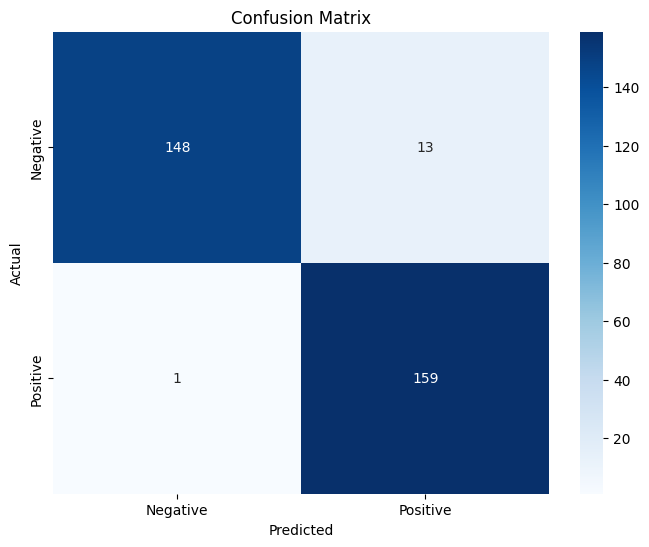

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.92      0.95       161
           1       0.92      0.99      0.96       160

    accuracy                           0.96       321
   macro avg       0.96      0.96      0.96       321
weighted avg       0.96      0.96      0.96       321


Metrics:
Accuracy: 0.9564
Precision: 0.9244
Recall: 0.9938
F1 Score: 0.9578


In [21]:
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Display confusion matrix
y_pred = (model.predict(X_test) > 0.5).astype(int).flatten()

# Create the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Display the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Display classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))
# Calculate accuracy, precision, recall, and F1-score
accuracy = np.sum(np.diag(cm)) / np.sum(cm)
precision = cm[1, 1] / (cm[1, 1] + cm[0, 1])
recall = cm[1, 1] / (cm[1, 1] + cm[1, 0])
f1_score = 2 * (precision * recall) / (precision + recall)

# Display metrics
print("\nMetrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1_score:.4f}")